# 사람이 말하는 단어를 인공지능 모델로 구분해보자

In [17]:
# 필요한 Library import
import numpy as np
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import random

In [2]:
# data load
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

# data list 확인
list(speech_data)

['wav_vals', 'label_vals']

In [3]:
# wav to spectrum function
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [4]:
# wav data를 spectrum data로 변환
temp = []
for i in speech_data['wav_vals']:
    temp.append(wav2spec(i))
new_speech_data = np.array(temp)

# shape 확인
new_speech_data.shape

(50620, 130, 126)

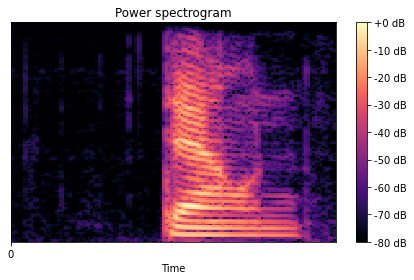

In [47]:
# spectrogram을 시각화
librosa.display.specshow(librosa.amplitude_to_db(new_speech_data[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [48]:
# 구분해야 할 Data Label list
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [49]:
# Label Data indexing
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [6]:
# 사이킷런의 split 함수를 이용하여 데이터 분리
from sklearn.model_selection import train_test_split

train_wav, test_wav, train_label, test_label = train_test_split(new_speech_data, 
                                                                label_data, 
                                                                test_size=0.2,
                                                                shuffle=True)
print(train_wav)

[[[1.59380250e-02 7.13781733e-03 1.53608841e-03 ... 1.54248159e-03
   4.53123869e-03 9.78559814e-03]
  [2.17618998e-02 9.59618110e-03 1.57164107e-03 ... 5.90319373e-03
   6.49490766e-03 5.09068510e-03]
  [2.70565208e-02 2.03438774e-02 8.66395049e-03 ... 1.57363154e-02
   1.21873757e-02 1.43520655e-02]
  ...
  [5.53774601e-03 2.45844712e-03 5.38504741e-04 ... 5.00130584e-04
   2.49551050e-03 4.56233229e-03]
  [5.35608968e-03 2.83431052e-03 7.35144422e-05 ... 1.63348566e-04
   2.53768149e-03 4.78881318e-03]
  [5.41124633e-03 2.67870678e-03 5.70870361e-05 ... 5.54922262e-05
   2.32503423e-03 4.63440316e-03]]

 [[1.54337406e-01 1.29861608e-01 7.69633427e-02 ... 9.33983028e-02
   4.15430292e-02 1.92480572e-02]
  [1.30844101e-01 4.66727950e-02 4.80340198e-02 ... 4.37052101e-02
   1.05584167e-01 1.14771739e-01]
  [1.53742999e-01 1.27823383e-01 1.25764191e-01 ... 8.76090676e-02
   1.59254208e-01 1.98840469e-01]
  ...
  [5.98525768e-03 2.70915497e-03 5.56553481e-04 ... 5.57002786e-04
   2.48523

In [7]:
# 데이터셋 확인
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (40496, 130, 126)
train labels :  (40496,)
test data :  (10124, 130, 126)
test labels :  (10124,)


In [8]:
# Hyper-parameter Setting
batch_size = 32
max_epochs = 10

In [9]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac10/aiffel/speech_recognition/models/wav'

In [10]:
# One-hot Encoding
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [11]:
# Dataset 함수 구성
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


In [12]:
# 모델 설계
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

In [13]:
# optimizer 설정
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [14]:
# callback 설정
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [15]:
# 모델 훈련
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1265/1265 [==============================] - ETA: 0s - loss: 0.7514 - accuracy: 0.7511
Epoch 00001: val_loss improved from inf to 0.31799, saving model to /home/ssac10/aiffel/speech_recognition/models/wav
1265/1265 [==============================] - 181s 143ms/step - loss: 0.7514 - accuracy: 0.7511 - val_loss: 0.3180 - val_accuracy: 0.8982
Epoch 2/10
1265/1265 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9202
Epoch 00002: val_loss improved from 0.31799 to 0.20810, saving model to /home/ssac10/aiffel/speech_recognition/models/wav
1265/1265 [==============================] - 179s 141ms/step - loss: 0.2533 - accuracy: 0.9202 - val_loss: 0.2081 - val_accuracy: 0.9352
Epoch 3/10
1265/1265 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9444
Epoch 00003: val_loss improved from 0.20810 to 0.17575, saving model to /home/ssac10/aiffel/speech_recognition/models/wav
1265/1265 [==============================] - 179s 141ms/step - loss: 0

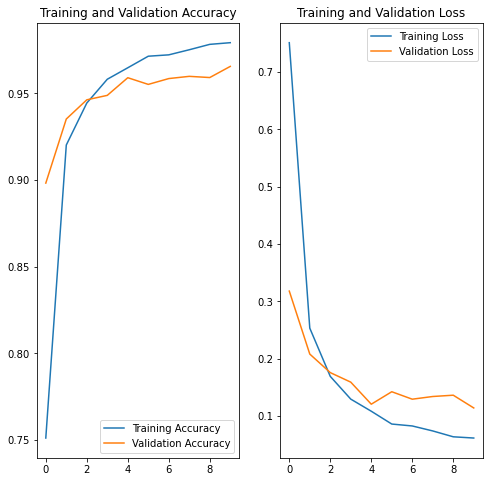

In [18]:
# 훈련 결과 시각화
acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# test 데이터와 비교
results = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

317/317 [==============================] - 26s 81ms/step - loss: 0.1140 - accuracy: 0.9656
loss value: 0.114
accuracy value: 96.5626%


In [20]:
# checkpoint callback 함수에서 저장한 weight 불러오기
model_wav.load_weights(checkpoint_dir)

In [21]:
# test 데이터와 비교
results_callback = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results_callback[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results_callback[1]*100))

317/317 [==============================] - 10s 33ms/step - loss: 0.1140 - accuracy: 0.9656
loss value: 0.114
accuracy value: 96.5626%


In [46]:
# 예측 데이터
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(16380,), rate=16380)
# 실제 데이터가 맞는지 확인
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

label :  left
y_pred: left(Correct!)


# 회고록

- 예전에 음악에 관심이 많았을 때 더 좋은 음질로 노래를 듣기 위해서 공부했을 때의 지식이 과제를 해결하는데 많은 도움이 된 것 같다.
- Wave Classification은 아무래도 데이터가 많아서 그런지 Image Classification이나 NLP보다 훨씬 parameter도 많고 시간도 오래 걸리는 것 같다.
- skip-connection 모델을 알고 있다는 전제하의 학습 노드였는데 사실 잘 몰라서 조금 더 찾아봐야 할 것 같다.
- skip-connection 을 이용하니까 overfitting은 줄어들은 것 같지만 실제로 정확도에는 큰 차이가 없는 것 같다.
- LMS 할 땐 batch_size를 32로 해도 메모리가 남길래 64로 변경해서 진행했었는데, Spectrum으로 변경하니까 parameter 수가 훨씬 많아져서 그런지 batch_size를 32로 조정해도 커널이 자꾸 죽어서 train_size를 줄이는 방향으로 겨우 model을 train시켰다.
- Spectrum을 1D-array로 reshape하여 train한 결과는 약 91%의 정확도가 나왔다!
- 1D-array에 Skip-connect을 적용해봤더니 적용하기 전과 큰 차이는 없는 것 같다.
- 2D-array로 reshape하여 2D-Conv Layer로 model을 train했더니 무려 96%의 정확도가 나왔다! 확실히 차원이 올라갈 수록 특징을 잡아내는 능력은 향상되는 것 같다. 대신 parameter의 수가 어마어마해져서 1epoch당 거의 5분 이상 걸려서 10epoch을 모두 진행하는 데 거의 1시간 정도가 걸렸다.
- 1D-array보다 2D-array쪽이 epoch을 거듭할 수록 train_loss와 val_loss의 차이가 벌어지는 정도가 덜했다. Overfitting이 덜하다는 의미인 것 같다. 실제로 결과도 더 좋았다.

### 추가로 1D-Conv 테스트 결과와 1D-Conv Skip Connection을 적용한 결과
[1D-Conv](./speech_recognition.ipynb)   
[1D-Conv_skip_connection](./speech_recognition-skip.ipynb)